## This assignment is designed for automated pathology detection for Medical Images in a relalistic setup, i.e. each image may have multiple pathologies/disorders. 
### The goal, for you as an MLE, is to design models and methods to predictively detect pathological images and explain the pathology sites in the image data.

## Data for this assignment is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview
Explanation of the data set:
The training data set contains 3435 retinal images that represent multiple pathological disorders. The patholgy classes and corresponding labels are: included in 'train.csv' file and each image can have more than one class category (multiple pathologies).
The labels for each image are

```
-opacity (0), 
-diabetic retinopathy (1), 
-glaucoma (2),
-macular edema (3),
-macular degeneration (4),
-retinal vascular occlusion (5)
-normal (6)
```
The test data set contains 350 unlabelled images.

# For this assignment, you are working with specialists for Diabetic Retinopathy and Glaucoma only, and your client is interested in a predictive learning model along with feature explanability and self-learning for Diabetic Retinopathy and Glaucoma vs. Normal images.
# Design models and methods for the following tasks. Each task should be accompanied by code, plots/images (if applicable), tables (if applicable) and text:
## Task 1: Build a classification model for Diabetic Retinopathy and Glaucoma vs normal images. You may consider multi-class classification vs. all-vs-one classification. Clearly state your choice and share details of your model, paremeters and hyper-paramaterization pprocess. (60 points)
```
a. Perform 70/30 data split and report performance scores on the test data set.
b. You can choose to apply any data augmentation strategy. 
Explain your methods and rationale behind parameter selection.
c. Show Training-validation curves to ensure overfitting and underfitting is avoided.
```
## Task 2: Visualize the heatmap/saliency/features using any method of your choice to demonstrate what regions of interest contribute to Diabetic Retinopathy and Glaucoma, respectively. (25 points)
```
Submit images/folder of images with heatmaps/features aligned on top of the images, or corresponding bounding boxes, and report what regions of interest in your opinion represent the pathological sites.
```

## Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.(15 points)
[You may use any method of your choice, one possible way is mentioned below.] 

```
Hint: 
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. (20 points)
```

## [Hint: If you are wondering how to use the "dense layer representative of an image" in step 2, see this exercise that extracts a [1,2048] dense representattive from an image using the InceptionV3 pre-trained model.]
https://colab.research.google.com/drive/14-6qRGARgBSj4isZk86zKQtyIT2f9Wu1#scrollTo=_IqraxtP4Ex3


## Good Luck!

In [66]:
# General Imports
import os               # importing data
import sys
import numpy as np      # linear algebra
import pandas as pd     # data processing, CSV file I/O (e.g. pd.read_csv)

# Tensorflow
import tensorflow as tf
import tensorflow.keras as keras
print("TensorFlow Version: ", tf.__version__) # In case there are issues with model fitting, I know what version of tensorflow I have

# Image Stuff
import IPython.display as display
import PIL.Image

TensorFlow Version:  2.6.1


## Task 0: Data Wrangling

In [67]:
# Various directory paths for convenience
from os.path import dirname, abspath, join, exists

PROJECT_DIR = dirname((abspath('')))                            # project directory
HIDDEN_FILES_DIR = abspath(join(PROJECT_DIR, 'hidden_files'))   # hidden_files directory (where data is stored)
DATA_DIR = abspath(join(HIDDEN_FILES_DIR, 'midterm_data'))      # directory of Data (renamed to midterm_data)
TRAIN_DIR = abspath(join(DATA_DIR, 'train'))                    # directory with train data ['train/', 'train.csv']
TRAIN_IMAGE_DIR = abspath(join(TRAIN_DIR, 'train'))             # directory with train images (labeled)
TEST_IMAGE_DIR = abspath(join(DATA_DIR, 'test', 'test'))        # directory with test images (unlabeled)

In [68]:
# Unzip midterm data (note, if you are running this, add Data.zip ~ renamed to midterm_data.zip to ../hidden_files/)
if not exists(TRAIN_DIR):
    data_zip_file_path = join(HIDDEN_FILES_DIR,'midterm_data.zip')
    !unzip data_zip_file_path                    # already unzipped, so if this does not work, use below line
    #!unzip ../hidden_files/midterm_data.zip     # will have to change this potentially for windowsß

print(os.listdir(TRAIN_DIR))
# should return ['train', 'train.csv'].
# *NOTE: .DS_Store might also appear in this directory if on mac. This file is ignored in the .gitignore.

['.DS_Store', 'train', 'train.csv']


In [69]:
# Load training data
data = pd.read_csv(join(TRAIN_DIR, "train.csv"))

# Examine first few rows to better understand data
data.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


In [70]:
# Take a look a the data types, count
data.info(memory_usage=True) # memory usage will tell us how much memory the data takes. Not important for this project, but a cool stat nontheless.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3435 entries, 0 to 3434
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   filename                    3435 non-null   object
 1   opacity                     3435 non-null   int64 
 2   diabetic retinopathy        3435 non-null   int64 
 3   glaucoma                    3435 non-null   int64 
 4   macular edema               3435 non-null   int64 
 5   macular degeneration        3435 non-null   int64 
 6   retinal vascular occlusion  3435 non-null   int64 
 7   normal                      3435 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 214.8+ KB


From an initial inspection, there are additional labels per image that we are not concerned about, namely: opacity, macular edema, macular degeneration, retinal vascular occlusion, and normal. Those labels will be dropped from examples with either diabetic retinopathy and/or glaucoma labels present. Examples without diabetic retinopaty or glaucoma will belong to a third category, other (which will include images with the normal category). This is important so we can have examples which are true negatives i.e. not diabetic retinopathy and/or glaucoma.

### Visualizing Examples

Lets start with visualizing a single image

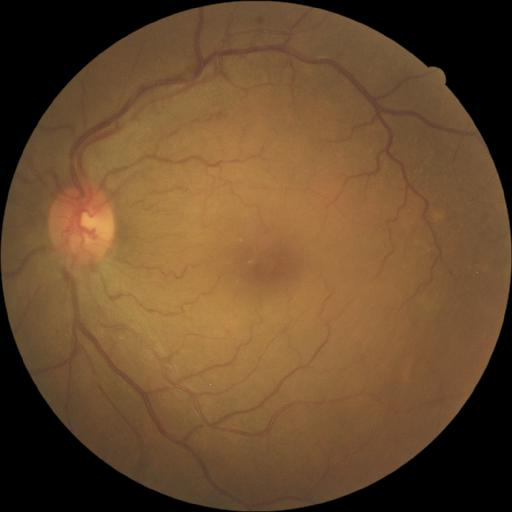

**** 		Image Labels		 ****
filename                      027f5a492a33.jpg
opacity                                      1
diabetic retinopathy                         0
glaucoma                                     0
macular edema                                0
macular degeneration                         0
retinal vascular occlusion                   1
normal                                       0
Name: 1891, dtype: object


In [71]:
# chose a random retina
num = np.random.randint(1, data.shape[0])

# display it
display.display(PIL.Image.open(join(TRAIN_IMAGE_DIR, data['filename'][num])))

# show image labels
print("**** \t\tImage Labels\t\t ****")
print(data.iloc[num])


## "It kind of looks like mars" - Christian "I'm a bit of a scientist myself" Welling

At this point (since I'm not quite the doctor or eye expert), it is difficult to pick out exactly what features in the image matter yet.

### Label Distribution
Lets look at the distribution of labels. does each example have just one label? Are there examples that share glaucoma and diabetic retinopathy labels?

In [72]:
# distribution of lables with respect to oneanother before we remove and group non glaucoma and diabetic retinopathy labels
for label in data.columns[2:]:
    print("Distribution of", label)
    print(data[label].value_counts())

Distribution of diabetic retinopathy
0    2680
1     755
Name: diabetic retinopathy, dtype: int64
Distribution of glaucoma
0    2838
1     597
Name: glaucoma, dtype: int64
Distribution of macular edema
0    2919
1     516
Name: macular edema, dtype: int64
Distribution of macular degeneration
0    2861
1     574
Name: macular degeneration, dtype: int64
Distribution of retinal vascular occlusion
0    2995
1     440
Name: retinal vascular occlusion, dtype: int64
Distribution of normal
0    2910
1     525
Name: normal, dtype: int64


While im not math expert, with a total of only 3435 entries, the only way the math above works out is if more than one label can be 1 for the numerous examples.

### Updating Data Frame For Our Usecase
```
1. Remove irrelevant labels
2. Group examples without retinopathy and glaucoma into a third class, other (all other label columns, including other, will be replaced with 'other') 
```

In [73]:
# drop the columns (labels) that are outside the scope of this problem
data = data[['filename','diabetic retinopathy', 'glaucoma']]

# quick verification this worked
data.head()

,filename,diabetic retinopathy,glaucoma
0,c24a1b14d253.jpg,0,0
1,9ee905a41651.jpg,0,0
2,3f58d128caf6.jpg,0,1
3,4ce6599e7b20.jpg,0,0
4,0def470360e4.jpg,0,0


In [74]:
# add third label 'other' to account for examples which are not diabetic retinopathy or glaucoma
data['other'] = 0
data['other'] = ((data['glaucoma'] == 0) & (data['diabetic retinopathy'] == 0)).astype(int)
data.head(10)       # lets see a few more examples

,filename,diabetic retinopathy,glaucoma,other
0,c24a1b14d253.jpg,0,0,1
1,9ee905a41651.jpg,0,0,1
2,3f58d128caf6.jpg,0,1,0
3,4ce6599e7b20.jpg,0,0,1
4,0def470360e4.jpg,0,0,1
5,e80c3ba691f9.jpg,0,0,1
6,37b8fa3b6dce.jpg,0,0,1
7,b5740f9b3508.jpg,0,0,1
8,d7596283f399.jpg,0,0,1
9,1083d0bd0ff8.jpg,0,0,1


In [75]:
# new distribution of labels
data.info()
for label in data.columns[1:]:
    print("Distribution of", label)
    print(data[label].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3435 entries, 0 to 3434
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   filename              3435 non-null   object
 1   diabetic retinopathy  3435 non-null   int64 
 2   glaucoma              3435 non-null   int64 
 3   other                 3435 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 107.5+ KB
Distribution of diabetic retinopathy
0    2680
1     755
Name: diabetic retinopathy, dtype: int64
Distribution of glaucoma
0    2838
1     597
Name: glaucoma, dtype: int64
Distribution of other
1    2102
0    1333
Name: other, dtype: int64


In [76]:
# verify math works out (number of classes present adds up to total number of examples)
LABELS = data.columns[1:]                                                                   # will reference throughout notebook
def build_label(row):
    return ",".join([labels[idx] for idx, val in enumerate(row[1:]) if val == 1])
        
print(data.apply(lambda x: build_label(x), axis=1).value_counts())
print(f'Total Number of Examples: {data.shape[0]}')

other                            2102
diabetic retinopathy              736
glaucoma                          578
diabetic retinopathy,glaucoma      19
dtype: int64
Total Number of Examples: 3435


## Task 1: Classification of Diabetic Retanopathy and Glaucoma vs Normal (Other <- Our label name) Images:

```
a. Perform 70/30 data split and report performance scores on the test data set.
b. You can choose to apply any data augmentation strategy. 
Explain your methods and rationale behind parameter selection.
c. Show Training-validation curves to ensure overfitting and underfitting is avoided.
```

### Options: Multi-class vs. all-vs-one model

**Multi-Class:**
1. can use one-hot-encoding approach to generate probabilities for multiple classes
2. easier to add additional classifications schemes

**All-vs-one:**
1. will probably need more than one model for each class trying to identify.
2. Can probabably share some of the eariler NN (transfer learning) for each model.

### Expert analysis and decision making:

```
me at 3:00 am:  If i am understanding this correctly, option 2 requires more than one model...I think we know what choice I am going with...

also me:        ...Multi-Class...its Multi-Class...

again, me:      Ain't nobody got time for more than one model.

me?:            Wait...Surely, Multi-Class is more accurate...right?
```

### Split Data Into Training & Validation Sets
```
* Use a 70/30 data split
```

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
# split data into test/validation sets and make it a tensor
train_data, validation_data = train_test_split(data, test_size=0.3, random_state=42) # 42 is the meaning of life

In [79]:
# taking a peek at train_data
print(f"Training Data Shape: {train_data.shape}")
train_data.head(10) # still a tensor

Training Data Shape: (2404, 4)


,filename,diabetic retinopathy,glaucoma,other
1431,8ce79b47bb8e.jpg,1,0,0
3353,97d752293c76.jpg,0,0,1
1864,f55fe90b5359.jpg,0,0,1
2573,2da0cd28c0a1.jpg,1,0,0
2894,8cd457a348bc.jpg,0,1,0
994,fe85c499a133.jpg,0,1,0
464,c7a4cc0ea725.jpg,0,1,0
2431,73a0537586f9.jpg,1,1,0
2750,b09d3011b063.jpg,1,0,0
3338,d4ef9a6f3fa2.jpg,0,0,1


In [80]:
# taking a peek at validation_data (shhh, don't tell anyone)
print(f"Validation Data Shape: {validation_data.shape}")
validation_data.head(10) # still a tensor

Validation Data Shape: (1031, 4)


,filename,diabetic retinopathy,glaucoma,other
1713,338d390b0d66.jpg,0,1,0
1637,fecbf8136bd5.jpg,0,0,1
929,87d08361bcbc.jpg,0,0,1
2966,da0d0c7e9336.jpg,0,0,1
203,4271f6a1bc34.jpg,0,0,1
1494,ac713827c7cb.jpg,0,0,1
2380,19a39631f0b2.jpg,0,1,0
1465,92cd7989f9ff.jpg,0,0,1
557,76cdc6a3e9a9.jpg,0,0,1
567,6ef741ba4c43.jpg,1,0,0


### Data Augmentation
```
See below for expert -- critically acclaimed -- strategy
```

## "Totally not just going to rip the data generator and augmentation from some previous UNet assignment because it worked there..." - Christian "I would never" Welling

In [81]:
# lift code from MLE for training generator & data augmentation. use unet-helper functions and lift directly. 
# unet-helper functions -> prints out metrics later when I need it 

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [83]:
# data generation and augmentation...wow where have we seen this before???
data_gen_args = dict( 
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    channel_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
)
train_datagen = ImageDataGenerator(**data_gen_args)

In [84]:
# One-hot-encode labels 
def build_label_list(row):
    return [LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1]                 # labels was defined earlier
        
train_data["label"] = train_data.apply(lambda x: build_label_list(x), axis=1)
validation_data["label"] = validation_data.apply(lambda x: build_label_list(x), axis=1)

In [92]:
# verify change
print("Training Data:")
train_data.head(10)

Training Data:


,filename,diabetic retinopathy,glaucoma,other,label
1431,8ce79b47bb8e.jpg,1,0,0,[diabetic retinopathy]
3353,97d752293c76.jpg,0,0,1,[other]
1864,f55fe90b5359.jpg,0,0,1,[other]
2573,2da0cd28c0a1.jpg,1,0,0,[diabetic retinopathy]
2894,8cd457a348bc.jpg,0,1,0,[glaucoma]
994,fe85c499a133.jpg,0,1,0,[glaucoma]
464,c7a4cc0ea725.jpg,0,1,0,[glaucoma]
2431,73a0537586f9.jpg,1,1,0,"[diabetic retinopathy, glaucoma]"
2750,b09d3011b063.jpg,1,0,0,[diabetic retinopathy]
3338,d4ef9a6f3fa2.jpg,0,0,1,[other]


In [91]:
print("Validation Data:")
validation_data.head(10)

Validation Data:


,filename,diabetic retinopathy,glaucoma,other,label
1713,338d390b0d66.jpg,0,1,0,[glaucoma]
1637,fecbf8136bd5.jpg,0,0,1,[other]
929,87d08361bcbc.jpg,0,0,1,[other]
2966,da0d0c7e9336.jpg,0,0,1,[other]
203,4271f6a1bc34.jpg,0,0,1,[other]
1494,ac713827c7cb.jpg,0,0,1,[other]
2380,19a39631f0b2.jpg,0,1,0,[glaucoma]
1465,92cd7989f9ff.jpg,0,0,1,[other]
557,76cdc6a3e9a9.jpg,0,0,1,[other]
567,6ef741ba4c43.jpg,1,0,0,[diabetic retinopathy]


## "And on the 5th day, God said: 'Augment them tensors!'" - Christian's Diary, Verse 10, Ch 1

In [93]:
# but first, some hyper parameters (will define others later)
IMAGE_SIZE = 224                            # Image size is [224x224]
BATCH_SIZE = 64                             # I feel like 64 is a nice number.  

In [94]:
# augment tensors
train_gen = train_datagen.flow_from_dataframe(dataframe=train_data,
                                              directory=TRAIN_IMAGE_DIR,
                                              x_col="filename",
                                              y_col="label",
                                              class_mode="categorical",
                                              target_size=(
                                                  IMAGE_SIZE, IMAGE_SIZE),
                                              batch_size=BATCH_SIZE)

validation_gen = train_datagen.flow_from_dataframe(dataframe=validation_data,
                                            directory=TRAIN_IMAGE_DIR,
                                            x_col="filename",
                                            y_col="label",
                                            class_mode="categorical",
                                            shuffle=False,
                                            target_size=(
                                                IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size=BATCH_SIZE)

Found 2404 validated image filenames belonging to 3 classes.
Found 1031 validated image filenames belonging to 3 classes.


### Model Selection

Why reinvent the wheel? Since the model has worked so well on similar image classification problems, I will attempt to use the ResNet50 model pretrained on the ImageNet dataset (spoiler, the model performes wonderfully). The classifier of the ResNet50 model will be replaced with a new dense layer to make the output suit our problem.

In [96]:
# additional hyperparameters for training
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 100             

In my experience with classification models, 100 epoch should be enough and a low learning rate like 0.001 is a good starting point. The LEARNING_RATE_SCHEDULE_FACTOR and LEARNING_RATE_SCHEDULE_PATIENCE are values I found from another ResNet50 application.

In [97]:
# modified ResNet50 model
base_model = keras.applications.ResNet50(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                                    include_top=False,
                                    weights='imagenet')
base_model.trainable = True

model = keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(len(LABELS), activation='sigmoid')
])

# print out model summary
model.summary()

2022-01-21 00:03:21.032433: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


### Model Callbacks
```
There are two callbacks that are necessary for training:

1. Saving the best model on the validation set
2. Reducing learning rate during training
```

In [98]:
# define callbacks

# callback to save the best model based off of the validation set
save_best_model_cb = keras.callbacks.ModelCheckpoint(
        "resnet50.h5", monitor="val_accuracy", save_best_only=True, save_weights_only=True, verbose=1, mode='max'),

# callback to reduce the learning rate
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', factor=LEARNING_RATE_SCHEDULE_FACTOR,
        mode='max', patience=LEARNING_RATE_SCHEDULE_PATIENCE, min_lr=1e-8, verbose=1)

callbacks = [save_best_model_cb, reduce_lr_cb]

### Train Model

Silent prayer that training does not take forever

In [100]:
# tensorflow needs to know if the GPU is going to be available during training
if len(tf.config.experimental.list_physical_devices('GPU')):
    DEVICE = '/gpu:0'
    print("TensorFlow is using the GPU")
else: 
    DEVICE = '/cpu:0' 
    print("TensorFlow is using the CPU only")

TensorFlow is using the CPU only


In [101]:
# train model
with tf.device(DEVICE):
    steps_per_epoch = train_gen.n // BATCH_SIZE
    validation_steps = validation_gen.n // BATCH_SIZE

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_gen,
                        steps_per_epoch=steps_per_epoch,
                        epochs=MAX_EPOCHS,
                        verbose=1,
                        validation_data=validation_gen,
                        validation_steps=validation_steps,
                        callbacks=callbacks)

/Users/christianwelling/Fourthbrain/Fourthbrain/fourthbrain_venv/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/christianwelling/Fourthbrain/Fourthbrain/fourthbrain_venv/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2022-01-21 00:14:39.773751: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
 4/37 [==>...........................] - ETA: 40:44 - loss: 0.6793 - accuracy: 0.5526

KeyboardInterrupt: 